In [1]:
import numpy as np
from qiskit import __qiskit_version__
from qiskit.chemistry.drivers import PySCFDriver, PyQuanteDriver, UnitsType
from qiskit.chemistry import FermionicOperator
from qiskit.aqua.algorithms import VQE, ExactEigensolver
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.aqua import QuantumInstance
from qiskit import Aer
from qiskit.chemistry.algorithms.q_equation_of_motion.q_equation_of_motion import QEquationOfMotion
from qiskit.visualization import plot_histogram
from qiskit import IBMQ
from qiskit.providers.aer import noise

In [2]:
__qiskit_version__

{'qiskit-terra': '0.11.1',
 'qiskit-aer': '0.3.4',
 'qiskit-ignis': '0.2.0',
 'qiskit-ibmq-provider': '0.4.5',
 'qiskit-aqua': '0.6.2',
 'qiskit': '0.14.1'}

## 1. Run a Hartree-Fock/STO-3G calculation on a Hydrogen molecule at equilibrium bond length. Use the built-in PySCF driver for example. Extract the 1- and 2-electron integrals, the number of particles, the number of orbitals and the Hartree-Fock energy.

In [24]:
driver = PySCFDriver(atom='H .0 .0 .0; H .0 .0 0.735', unit=UnitsType.ANGSTROM,
                     charge=0, spin=0, basis='sto3g')
molecule = driver.run()

h1 = molecule.one_body_integrals
h2 = molecule.two_body_integrals

nuclear_repulsion_energy = molecule.nuclear_repulsion_energy

num_particles = molecule.num_alpha + molecule.num_beta
num_spin_orbitals = molecule.num_orbitals * 2

print("HF energy: {}".format(molecule.hf_energy - molecule.nuclear_repulsion_energy))
print("# of electrons: {}".format(num_particles))
print("# of spin orbitals: {}".format(num_spin_orbitals))

HF energy: -1.8369679912029846
# of electrons: 2
# of spin orbitals: 4


## 2. Prepare the Hamiltonian in the fermionic representation.

In [25]:
ferop = FermionicOperator(h1=h1, h2=h2)

## 3. Prepare the Hamiltonian in the qubit representation by mapping the fermionic Hamiltonian using the Jordan-Wigner transformation. Print the Pauli terms of the Hamiltonian.

In [26]:
map_type = 'jordan_wigner'
qubitop = ferop.mapping(map_type=map_type)
print(qubitop.print_details())

IIII	(-0.8105479805373266+0j)
IIIZ	(0.17218393261915532+0j)
IIZI	(-0.22575349222402502+0j)
IZII	(0.17218393261915535+0j)
ZIII	(-0.225753492224025+0j)
IIZZ	(0.12091263261776639+0j)
IZIZ	(0.16892753870087923+0j)
XXYY	(0.04523279994605789+0j)
YYYY	(0.04523279994605789+0j)
XXXX	(0.04523279994605789+0j)
YYXX	(0.04523279994605789+0j)
ZIIZ	(0.16614543256382427+0j)
IZZI	(0.16614543256382427+0j)
ZIZI	(0.1746434306830047+0j)
ZZII	(0.12091263261776639+0j)



## 4. Calculate the exact eigenstates of the Hamiltonian by using the built-in ExactEigensolver.

In [27]:
exact_eigensolver = ExactEigensolver(qubitop, k=1<<qubitop.num_qubits)
ret = exact_eigensolver.run()
print('The ground state energy is: {:.12f}'.format(ret['eigvals'][0].real))
print('The ground state is:')
for i in range(1<<qubitop.num_qubits):
    print(np.binary_repr(i, width=qubitop.num_qubits), ret['eigvecs'][0][i])

The ground state energy is: -1.857275030202
The ground state is:
0000 0j
0001 0j
0010 0j
0011 0j
0100 0j
0101 (0.993760400885186+0j)
0110 0j
0111 0j
1000 0j
1001 0j
1010 (-0.11153593874852265+0j)
1011 0j
1100 0j
1101 0j
1110 0j
1111 0j


## 5. Prepare a Hartree-Fock initial state.

In [28]:
qubit_reduction = False
HF_state = HartreeFock(qubitop.num_qubits, num_spin_orbitals, num_particles, map_type, qubit_reduction)

## 6. Create a UCCSD variational form. Use the previously constructed initial state. 

In [29]:
var_form = UCCSD(qubitop.num_qubits, depth=1, 
                   num_orbitals=num_spin_orbitals, num_particles=num_particles, 
                   initial_state=HF_state, qubit_mapping=map_type, 
                   two_qubit_reduction=qubit_reduction)

## 7. Construct and visualize the corresponding circuit with a random set of parameters. Look for the entangling blocks corresponding to a 1-body or a 2-body excitation.

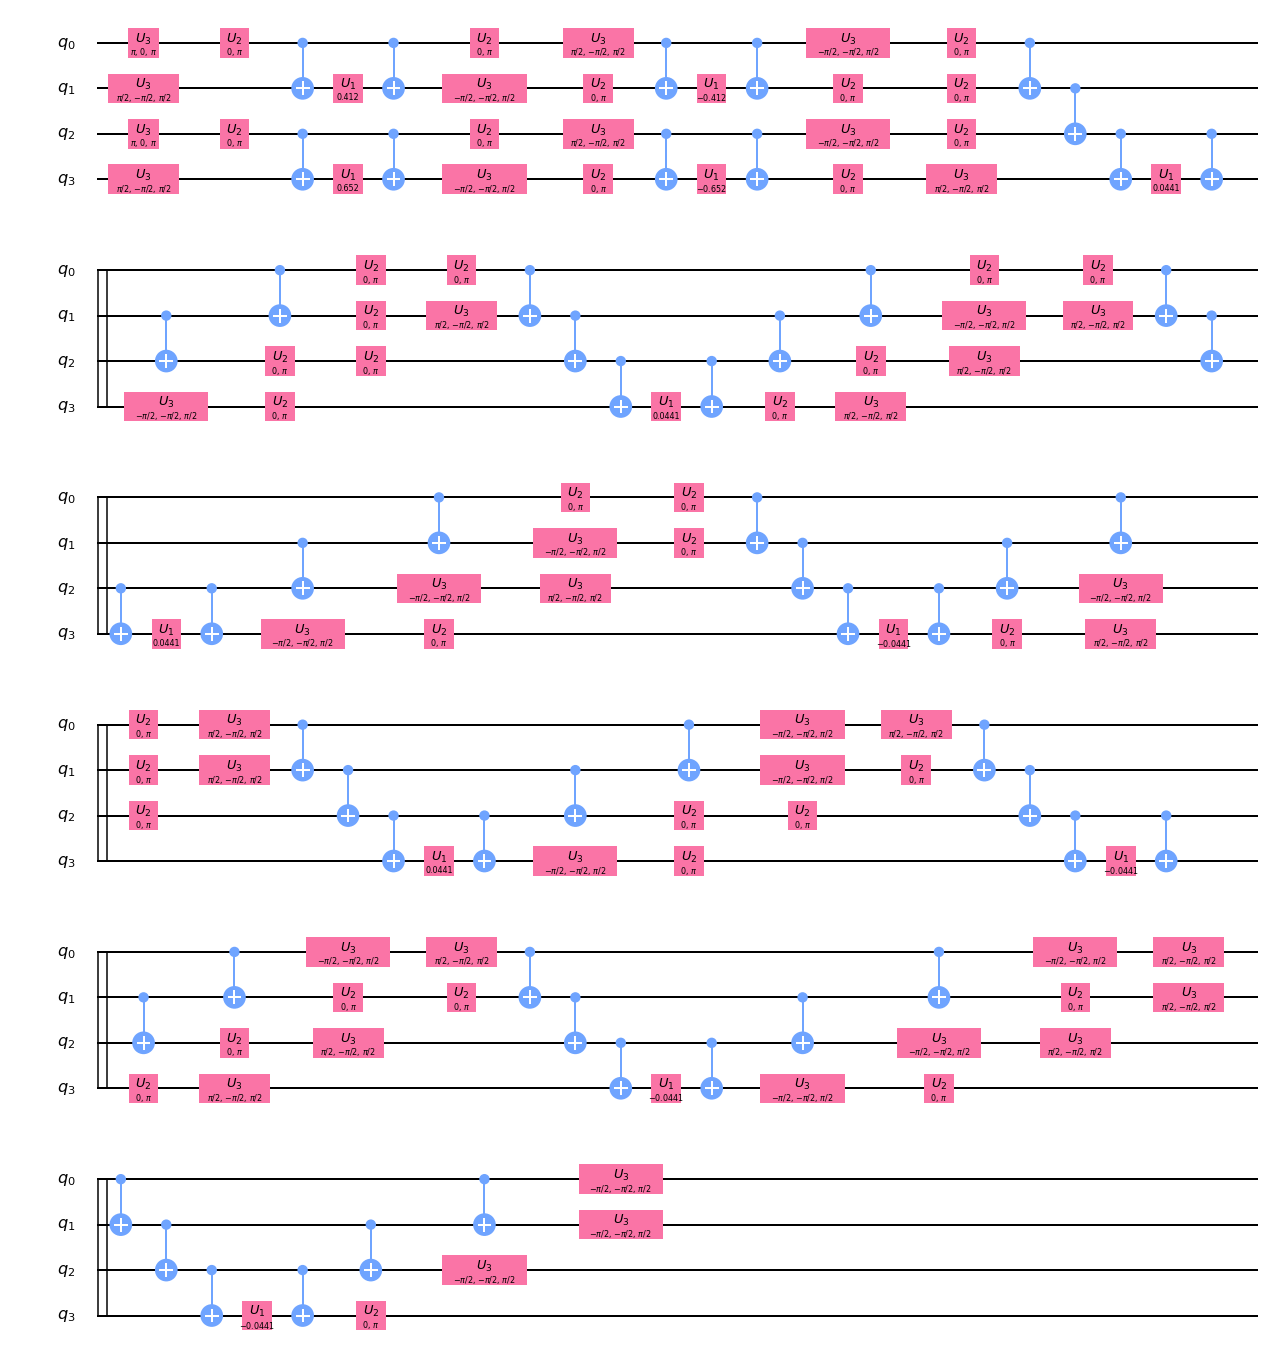

In [30]:
params = np.random.rand(var_form._num_parameters)
circuit = var_form.construct_circuit(params)
circuit.decompose().draw(output='mpl')

## 8. Run a VQE calculation on the statevector simulator. Use the COBYLA optimizer.

In [34]:
backend = Aer.get_backend('statevector_simulator')
import logging
from qiskit.chemistry import set_qiskit_chemistry_logging
set_qiskit_chemistry_logging(logging.INFO) # choose among DEBUG, INFO, WARNING, ERROR, CRITICAL and NOTSET


max_eval = 200
cobyla = COBYLA(maxiter=max_eval)

vqe = VQE(qubitop, var_form, cobyla)
quantum_instance = QuantumInstance(backend=backend)

results = vqe.run(quantum_instance)
print('The computed ground state energy is: {:.12f}'.format(results['eigvals'][0]))
print("Parameters: {}".format(results['opt_params']))

2020-02-07 14:15:55,993:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- quantum_instance: None
-- var_form: <qiskit.chemistry.components.variational_forms.uccsd.UCCSD object at 0x131038b10>
-- optimizer: <qiskit.aqua.components.optimizers.cobyla.COBYLA object at 0x12f4644d0>
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.adaptive.vqe.vqe.VQE object at 0x12b1eeb50>>
-- initial_point: [0. 0. 0.]
-- parameterized_circuits: None
-- use_simulator_snapshot_mode: None
-- ret: None
-- eval_time: None
-- callback: None
-- operator: Representation: paulis, qubits: 4, size: 15
-- eval_count: 0
-- aux_operators: []
-- auto_conversion: True
Variational Form: UCCSD
-- num_parameters: 3
-- num_qubits: 4
-- bounds: [(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)]
-- support_parameterized_circuit: True
-- z2_symmetries:

2020-02-07 14:15:56,635:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 43 returned -1.8572750273402625
2020-02-07 14:15:56,646:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 44 returned -1.8572750234558075
2020-02-07 14:15:56,659:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 45 returned -1.8572750245416993
2020-02-07 14:15:56,660:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Optimization complete in 0.6640160083770752 seconds.
Found opt_params [-4.54313157e-05  8.12814525e-05 -1.11776914e-01] in 45 evals


The computed ground state energy is: -1.857275024542
Parameters: [-4.54313157e-05  8.12814525e-05 -1.11776914e-01]


# ------------------------------------------------------------------------------

## 9. Construct the number operator in fermionic form and map it to the qubit form. Visualize the Pauli terms.

In [11]:
h1_nop = np.identity(qubitop.num_qubits)

fermionic_nop = FermionicOperator(h1=h1_nop)
qubit_nop = fermionic_nop.mapping(map_type=map_type)
print(qubit_nop.print_details())

IIII	(2+0j)
IIIZ	(-0.5+0j)
IIZI	(-0.5+0j)
IZII	(-0.5+0j)
ZIII	(-0.5+0j)



## 10. Get the expectation value of the number operator with the ground state found with the VQE and the statevector simulator.

In [12]:
wavefn = var_form.construct_circuit(results['opt_params'])
statevector_mode = True
use_simulator_snapshot_mode = True
circuits = qubit_nop.construct_evaluation_circuit(wavefn, statevector_mode, 
                                                  use_simulator_snapshot_mode=use_simulator_snapshot_mode)
results_2 = quantum_instance.execute(circuits)
avg, std = qubit_nop.evaluate_with_result(results_2, statevector_mode, 
                                          use_simulator_snapshot_mode=use_simulator_snapshot_mode)

print(round(np.real(avg),1))

2.0


## 11. Calculate the excited state energies of the H2 molecules by running a EOM calculation with the previously found ground state.

In [13]:
eom =  QEquationOfMotion(qubitop, qubitop.num_qubits, num_particles,
                 qubit_mapping=map_type)
gaps, _ = eom.calculate_excited_states(wavefn, quantum_instance = quantum_instance)

## 12. Compare the results with the exact energies obtained from the diagonalization of the Hamiltonian. At the moment qEOM computes the excited states with the same spin and particle number as the ground state. Measure the number operator on the exact eigenvectors to compare the qEOM energies with the correct exact energies. 

In [14]:
exact_energies = []
for i in range(1<<qubitop.num_qubits):
    state = ret['eigvecs'][i]
    nop_exp = qubit_nop.evaluate_with_statevector(state)
    if round(np.real(nop_exp[0]),1) == 2:
        exact_energies.append(np.real(ret['eigvals'][i]))

qeom_energies = [results['eigvals'][0]]
for i in range(len(gaps)):
    qeom_energies.append(qeom_energies[0]+gaps[i])
    
print('The exact energies are {}'.format(exact_energies))
print('The qEOM energies are {}'.format(qeom_energies))

The exact energies are [-1.8426866819057308, -1.2483517134177595, -1.2483517134177595, -1.248351713417759, -0.8848086402631494, -0.24576509272507552]
The qEOM energies are [-1.8426866738886214, -1.2483424863914783, -0.8847994114759381, -0.24575586336757005]


# ------------------------------------------------------------------------------

## 13. Create a quantum instance using the qasm simulator and 1000 shots. Re-run the VQE using this quantum instace and compare the results with the previous ones. Notice that the running time increases on the qasm simulator since it simulates the sampling of the wavefunction as it would be done (efficiently) on a quantum hardware.

In [15]:
backend_2 = Aer.get_backend('qasm_simulator')
shots = 1000
quantum_instance_2 = QuantumInstance(backend=backend_2, shots = shots)

results_3 = vqe.run(quantum_instance_2)

print('The computed ground state energy is: {:.12f}'.format(results_3['eigvals'][0]))
print("Parameters: {}".format(results_3['opt_params']))

The computed ground state energy is: -1.829575279673
Parameters: [-0.05115328 -0.05210419 -0.10139768]


## 14. Visualize the histogram representing the calculated ground state.

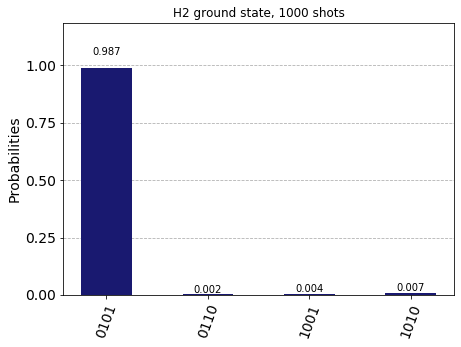

In [16]:
plot_histogram(results_3['eigvecs'][0], color='midnightblue', title="H2 ground state, 1000 shots")

## 15. Load you IBMQ account and print the list of backends you have access to.

In [17]:
IBMQ.save_account('679268b65869103438b43782543ef1cb532068e8dbc53d8acc34f160430eeb37655fbaf0351df831623d8bd5cf7496f8e21bd266cab2a963342dd737775465db', overwrite=True)
provider = IBMQ.load_account()

print(provider.backends())

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>]


## 16. Extract the noise model and the coupling map corresponding to one of the available hardwares (make sure the selected hardware has enough qubits). Create a QuantumInstance using the qasm simulator, 1000 shots and the resulting noise model and coupling map. Re-run the VQE using this quantum instace and compare the results with the previous ones. 

In [18]:
device = provider.get_backend('ibmqx2')
properties = device.properties()
coupling_map = device.configuration().coupling_map
noise_model = noise.device.basic_device_noise_model(properties)
basis_gates = noise_model.basis_gates

quantum_instance_3 = QuantumInstance(backend_2, shots=shots, basis_gates=basis_gates,
                                   coupling_map=coupling_map, noise_model=noise_model)

results_4 = vqe.run(quantum_instance_3)

print('The computed ground state energy is: {:.12f}'.format(results_3['eigvals'][0]))
print("Parameters: {}".format(results_3['opt_params']))

The computed ground state energy is: -1.829575279673
Parameters: [-0.05115328 -0.05210419 -0.10139768]


## 17. Visualize the histogram representing the calculated ground state.

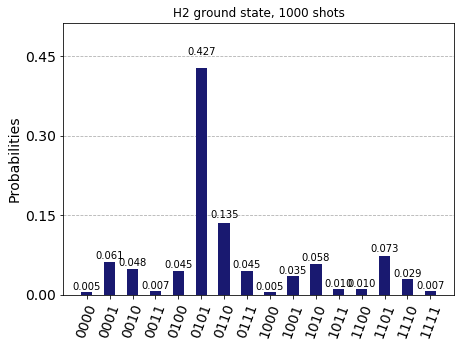

In [19]:
plot_histogram(results_4['eigvecs'][0], color='midnightblue', title="H2 ground state, 1000 shots")